# Fake News Classification - Simple models

## 1. Imports

In [1]:
!pip install clearml > /dev/null 2>&1

In [2]:
import os
import string
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk

### Logging

In [3]:
from clearml import Task
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = user_secrets.get_secret("clear_ml_access_key")
secret_key = user_secrets.get_secret("clear_ml_secret_key")

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

## 2. Data loading and preprocessing

Please note that all news without title of text are discarded.

In [17]:
data = pd.read_csv('../input/fake-news-classification/WELFake_Dataset.csv', index_col=0)
data = data.dropna()
y, X = data.loc[:, 'label'], data.loc[:, data.columns != 'label']
print(f'Total number of observations: {len(X)}\n')
print(f'Ratio of real and fake news:')
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

Total number of observations: 71537

Ratio of real and fake news:


real    0.510351
fake    0.489649
Name: label, dtype: float64

### Data preprocessing

In [5]:
X_clean_title = pd.DataFrame({"title": X['title']})

#### Merge title and text

In [ ]:
X_clean = pd.DataFrame({"title_text": X['title'] + " " + X['text']})

#### Clean data

In [6]:
stopwords = set(nltk.corpus.stopwords.words('english'))
porter_steemer = nltk.stem.PorterStemmer()

In [7]:
def remove_urls(text):
    URL_REGEX = r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    return re.sub(URL_REGEX, '', text)

def remove_non_alphabetical_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])
    
def stem_words(text):
    words = text.split()
    return ' '.join([porter_steemer.stem(word) for word in words])

def transform_text(text):
    text = remove_urls(text)
    text = remove_non_alphabetical_characters(text)
    text = text.lower()
    text = remove_stopwords(text)
    text = stem_words(text)
    
    return text

In [12]:
CLEAN_DATA_PATH = '../input/title-text-fake-news-clean/x_clean.csv'

if os.path.isfile(CLEAN_DATA_PATH):
    X_clean = pd.read_csv(CLEAN_DATA_PATH, index_col=0)
else:
    X_clean['title_text'] = X_clean['title_text'].apply(transform_text)

In [8]:
X_clean_title['title'] = X_clean_title['title'].apply(transform_text)

## Simple models

In [9]:
class SimpleModelEval:
    def __init__(self, X, y, models, logger, test_size=0.33, random_state=256):
        self.X = X
        self.y = y
        self.models = models
        self.logger = logger
        self.test_size = test_size
        self.random_state = random_state
        self.results = dict()
    
    def train_eval(self):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            self.X, self.y, test_size=0.33, random_state=256, stratify=self.y)
        
        for model in self.models:
            self.__train_eval_model(model, X_train, X_test, y_train, y_test)
    
    def __train_eval_model(self, model, X_train, X_test, y_train, y_test):
        model_name = model.__class__.__name__
        # Training model using training dataset
        model.fit(X_train, y_train)
        # Predicting the y variable for the testing dataset
        y_pred = model.predict(X_test)

        # Calculating accuracy score using predicted results and actual results
        acc = accuracy_score(y_test, y_pred)
        print(f"{model_name} fake news detection with {100 * round(acc, 4)}% accuracy")

        # Calculating False Positive Rate
        cf_matrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cf_matrix.ravel()
        fpr = fp / (fp + tn)
        
        # Calculating F1-score
        f1 = f1_score(y_test, y_pred)
        
        # Saving results
        self.results[model_name] = {
            "acc": acc, "fpr": fpr, "f1": f1
        }
        
        # Report scalars
        self.logger.report_scalar(title="Accuracy", series=model_name, value=acc, iteration=0)
        self.logger.report_scalar(title="False positive rate", series=model_name, value=fpr, iteration=0)
        self.logger.report_scalar(title="F1 score", series=model_name, value=f1, iteration=0)
        
        # The code below presents a confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

        ax.set_title(f'Confusion Matrix {model_name}\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');

        ax.xaxis.set_ticklabels(['False','True'])
        ax.yaxis.set_ticklabels(['False','True'])

        plt.show()
        
    def get_results(self):
        return pd.DataFrame.from_dict(self.results, orient='index')

### Title predictions

In [10]:
def eval_simple_models_on_title(max_features=10000, random_state=256):
    task = Task.create(project_name='mlcloud_fake_news', task_name='simple_models_title')
    task.mark_started()
    logger = task.get_logger()
    
    cv = CountVectorizer(max_features=max_features)
    X_bow = cv.fit_transform(X_clean_title.title).toarray()
    models = [GaussianNB(),
              LogisticRegression(max_iter=200),
              SGDClassifier(max_iter=100),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state, n_estimators=200),
              GradientBoostingClassifier()]
    sme = SimpleModelEval(X_bow, y, models, logger, random_state=random_state)
    sme.train_eval()
    
    task.mark_completed()
    task.close()

GaussianNB fake news detection with 69.96% accuracy


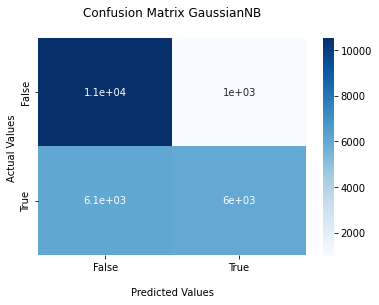

LogisticRegression fake news detection with 89.69% accuracy


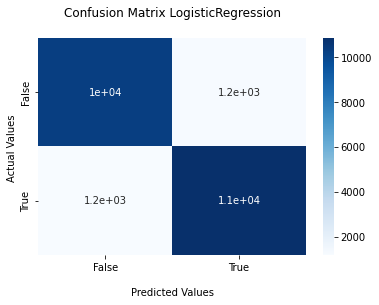

SGDClassifier fake news detection with 89.75% accuracy


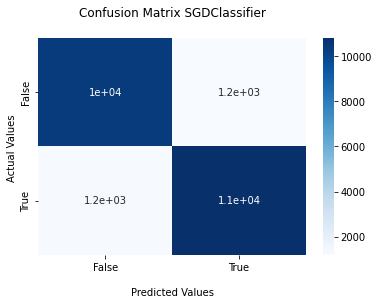

KNeighborsClassifier fake news detection with 63.46000000000001% accuracy


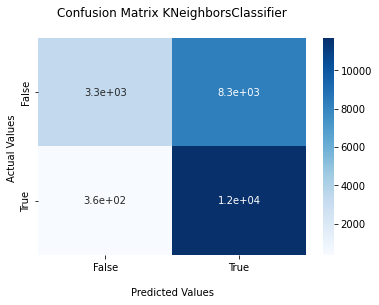

DecisionTreeClassifier fake news detection with 86.72% accuracy


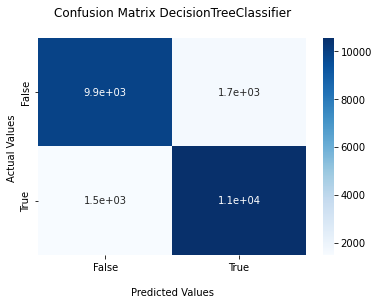

RandomForestClassifier fake news detection with 89.78% accuracy


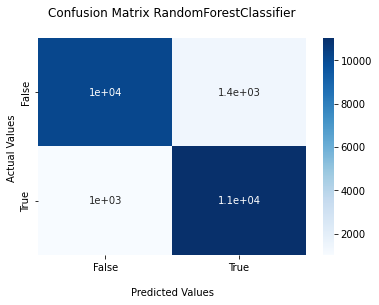

GradientBoostingClassifier fake news detection with 79.91% accuracy


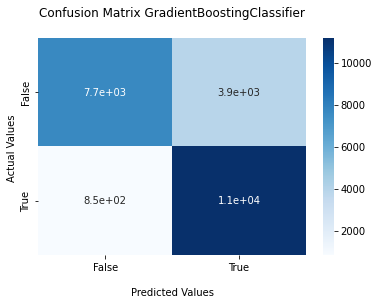

In [11]:
eval_simple_models_on_title()

### Title+text predictions

In [15]:
def eval_simple_models_on_title_text(max_features=1000, random_state=256):
    task = Task.create(project_name='mlcloud_fake_news', task_name='simple_models_title_text')
    task.mark_started()
    logger = task.get_logger()
    
    cv = CountVectorizer(max_features=max_features)
    X_bow = cv.fit_transform(X_clean.title_text[~X_clean.title_text.isna()]).toarray()
    y_tt = y[~X_clean.title_text.isna()]
    models = [GaussianNB(),
              LogisticRegression(max_iter=200),
              SGDClassifier(max_iter=100),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state, n_estimators=200),
              GradientBoostingClassifier()]
    sme = SimpleModelEval(X_bow, y_tt, models, logger, random_state=random_state)
    sme.train_eval()
    
    task.mark_completed()
    task.close()

GaussianNB fake news detection with 82.69999999999999% accuracy


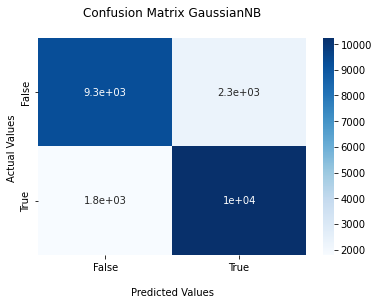

LogisticRegression fake news detection with 93.93% accuracy


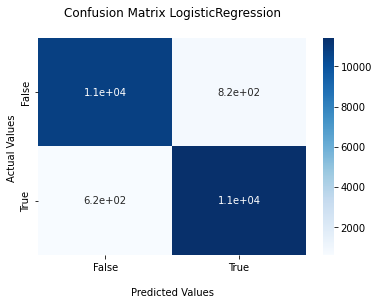

SGDClassifier fake news detection with 93.08999999999999% accuracy


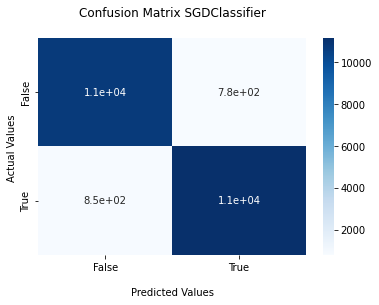

KNeighborsClassifier fake news detection with 81.46% accuracy


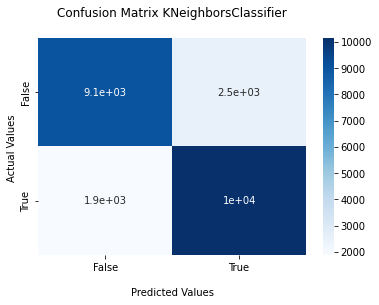

DecisionTreeClassifier fake news detection with 92.73% accuracy


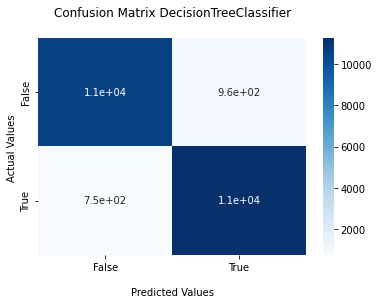

RandomForestClassifier fake news detection with 95.1% accuracy


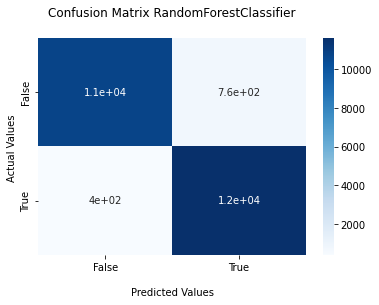

GradientBoostingClassifier fake news detection with 93.65% accuracy


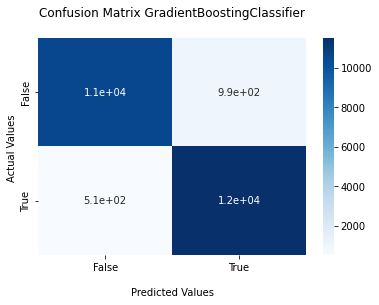

In [16]:
eval_simple_models_on_title_text()